In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 100)

### 銘柄情報: stock_listについて
* セクター情報や業種別コードは、グループ間における特徴がある場合は利用すると良いかもしれない
* 発行済み株式数は時価総額の算出に利用したいがが、この値は未来情報のため利用しない。  
  時系列データで発行済み株式数があれば、銘柄の規模で特徴がある場合は利用すると良いかもしれない。

In [2]:
stock_list = pd.read_csv('../data/stock_list.csv')
print('全銘柄数:', len(set(stock_list['Local Code'])))
stock_list.head(3)

全銘柄数: 3711


,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20201230,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2020/11/06,10928283.0
1,True,20201230,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/05,312430277.0
2,True,20201230,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/02,52656910.0


<メモ>  
決算短信の開示日から20営業日を経過した期間における各銘柄の最高値及び最安値を予測する。  
条件次第では、予測対象(prediction_target)から外れる。  

### 株価情報 : stock_price

In [3]:
stock_price = pd.read_csv('../data/stock_price.csv')
stock_price.head()

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
0,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250
1,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990
2,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867
3,1301,2016/01/07,2740.0,2760.0,2710.0,2710.0,2710.0,31400.0,0.1,2760.0,2016/01/06,2760.0,2016/01/06,-50.0,-1.812,2733.471
4,1301,2016/01/08,2700.0,2740.0,2690.0,2700.0,2700.0,26200.0,0.1,2710.0,2016/01/07,2710.0,2016/01/07,-10.0,-0.369,2709.122


In [4]:
stock_price.isnull().sum()

Local Code                                           0
EndOfDayQuote Date                                   0
EndOfDayQuote Open                                   0
EndOfDayQuote High                                   0
EndOfDayQuote Low                                    0
EndOfDayQuote Close                                  0
EndOfDayQuote ExchangeOfficialClose                  0
EndOfDayQuote Volume                                 0
EndOfDayQuote CumulativeAdjustmentFactor             0
EndOfDayQuote PreviousClose                          0
EndOfDayQuote PreviousCloseDate                    613
EndOfDayQuote PreviousExchangeOfficialClose          0
EndOfDayQuote PreviousExchangeOfficialCloseDate    481
EndOfDayQuote ChangeFromPreviousClose                0
EndOfDayQuote PercentChangeFromPreviousClose         0
EndOfDayQuote VWAP                                   0
dtype: int64

<メモ>  
価格情報に関しては欠損値はない。  
EndOfDayQuote PreviousCloseDate:前回の終値が発生した日  
EndOfDayQuote PreviousExchangeOfficialCloseDate: 前回の取引所公式終値が発生した日  
⇒前回が初回にあたる場合が欠損値になっている可能性が高い(これらを利用するつもりは無い為、確認はしない)  

### ファンダメンタル情報: stock_fin

In [5]:
stock_fin = pd.read_csv('../data/stock_fin.csv', index_col='base_date')
print('データ数:', len(stock_fin))
stock_fin.head(3)

データ数: 81797


,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare
base_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0
2016/01/04,3353,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/04,GB,False,21550.0,1038.0,1053.0,697.0,24949.0,7145.0,NaN,NaN,NaN,ConsolidatedJP,2016/02,Annual,2016.0,2016/01/04,GB,False,27800.0,1320.0,1310.0,840.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/02,Annual,2016.0,2016/01/04,2016/02/29,32.5,65.0
2016/01/04,4591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NonConsolidated,2016/03,Annual,2016.0,2016/01/04,GB,False,119.0,-474.0,-451.0,-452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,0.0,0.0


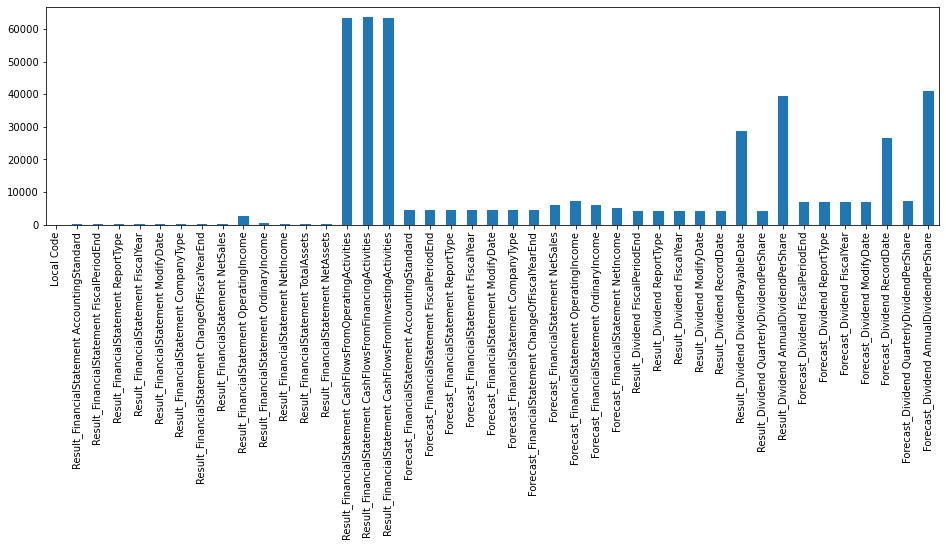

In [6]:
# 欠損値
plt.figure(figsize=(16, 4))
stock_fin.isnull().sum().plot.bar()

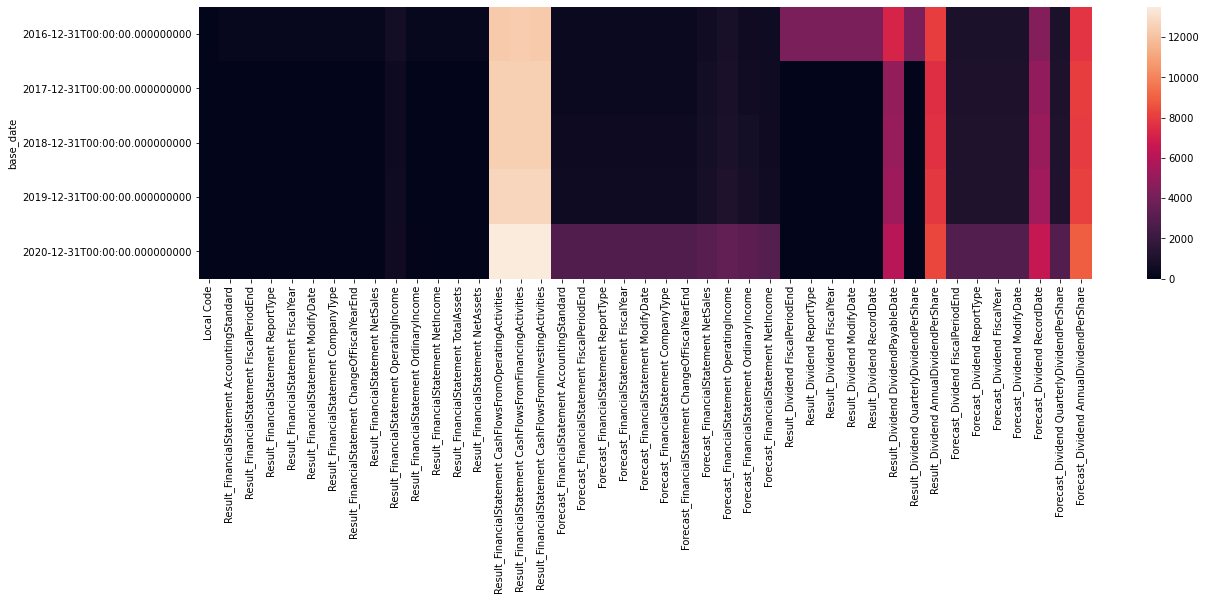

In [7]:
# Datetimeに変換
stock_fin.index = pd.to_datetime(stock_fin.index)


# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.isnull().resample('Y').sum(), ax=ax)

### 目的変数: stock_labels

In [10]:
stock_labels = pd.read_csv('../data/stock_labels.csv')
stock_labels.head(3)

,base_date,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
0,2016-01-04,1301,2016-01-12,0.01091,-0.04000,2016-01-19,0.01091,-0.05455,2016-02-02,0.01091,-0.08727
1,2016-01-05,1301,2016-01-13,0.00362,-0.04348,2016-01-20,0.00362,-0.07609,2016-02-03,0.00362,-0.09058
2,2016-01-06,1301,2016-01-14,0.00000,-0.05072,2016-01-21,0.00000,-0.08696,2016-02-04,0.00362,-0.09058


In [11]:
# 全銘柄の特徴
desc_tbl = stock_labels.drop('Local Code', axis=1).describe().copy()
desc_tbl

,label_high_5,label_low_5,label_high_10,label_low_10,label_high_20,label_low_20
count,4.201364e+06,4.201364e+06,4.187516e+06,4.187516e+06,4.151503e+06,4.151503e+06
mean,3.926970e-02,-3.389425e-02,5.958337e-02,-4.902147e-02,9.035046e-02,-6.947100e-02
std,6.192297e-02,4.193190e-02,9.230700e-02,5.592814e-02,1.386760e-01,7.437767e-02
min,-5.462800e-01,-7.949600e-01,-5.462800e-01,-7.963900e-01,-5.462800e-01,-8.289300e-01
25%,8.720000e-03,-4.666000e-02,1.399000e-02,-6.727250e-02,2.198000e-02,-9.583000e-02
50%,2.317000e-02,-2.236000e-02,3.510000e-02,-3.273000e-02,5.389000e-02,-4.743000e-02
75%,4.891000e-02,-7.950000e-03,7.359000e-02,-1.260000e-02,1.111100e-01,-1.899000e-02
max,5.567030e+00,3.295290e+00,6.198200e+00,3.295290e+00,8.029350e+00,1.855070e+00


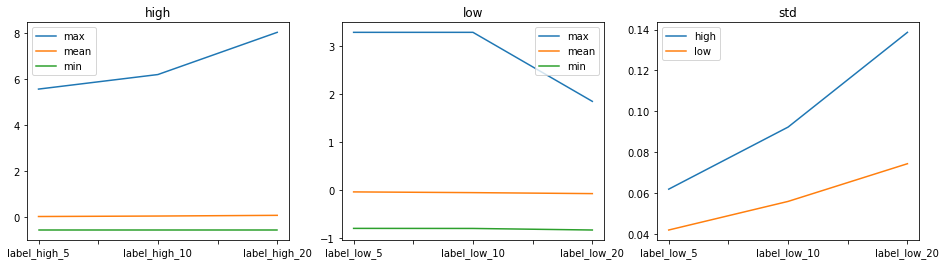

In [12]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
desc_tbl.iloc[7, [0, 2, 4]].plot() # max
desc_tbl.iloc[1, [0, 2, 4]].plot() # mean
desc_tbl.iloc[3, [0, 2, 4]].plot() # min
plt.title('high')
plt.legend()

plt.subplot(1, 3, 2)
desc_tbl.iloc[7, [1, 3, 5]].plot() #max
desc_tbl.iloc[1, [1, 3, 5]].plot() # mean
desc_tbl.iloc[3, [1, 3, 5]].plot() # min
plt.title('low')
plt.legend(loc='upper right')

plt.subplot(1, 3, 3)
desc_tbl.iloc[2, [0, 2, 4]].plot() #high std
desc_tbl.iloc[2, [1, 3, 5]].plot() #low std
plt.title('std')
plt.legend(['high', 'low'])

<メモ>  
* high: 最小値・平均値は一定だが、最大値は予測期間が長くなると大きくなる。それに伴い標準偏差も増加。
* low : 最小値・平均値は一定だが、最大値は予測期間が長くなると小さくなる。それに伴い標準偏差も増加。  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;⇒最小値が一定なのは、下落は急落することが多く、短い期間で価格に織り込まれているためだと思われる。

Text(0.5, 1.0, 'label_low_20')

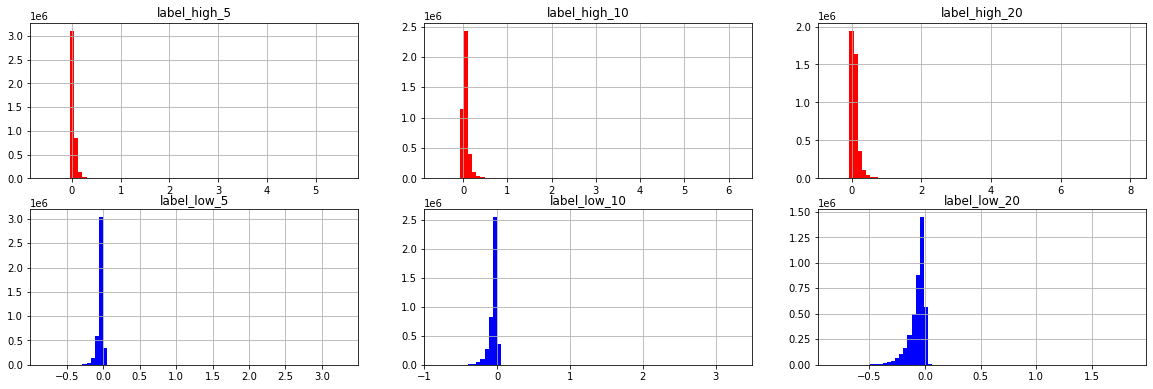

In [13]:
plt.figure(figsize=(20, 20))
plt.subplot(6, 3, 1)
stock_labels['label_high_5'].hist(bins=72, color='red')
plt.title('label_high_5')

plt.subplot(6, 3, 2)
stock_labels['label_high_10'].hist(bins=72, color='red')
plt.title('label_high_10')

plt.subplot(6, 3, 3)
stock_labels['label_high_20'].hist(bins=72, color='red')
plt.title('label_high_20')

plt.subplot(6, 3, 4)
stock_labels['label_low_5'].hist(bins=72, color='blue')
plt.title('label_low_5')

plt.subplot(6, 3, 5)
stock_labels['label_low_10'].hist(bins=72, color='blue')
plt.title('label_low_10')

plt.subplot(6, 3, 6)
stock_labels['label_low_20'].hist(bins=72, color='blue')
plt.title('label_low_20')


Text(0.5, 1.0, 'high_low_20')

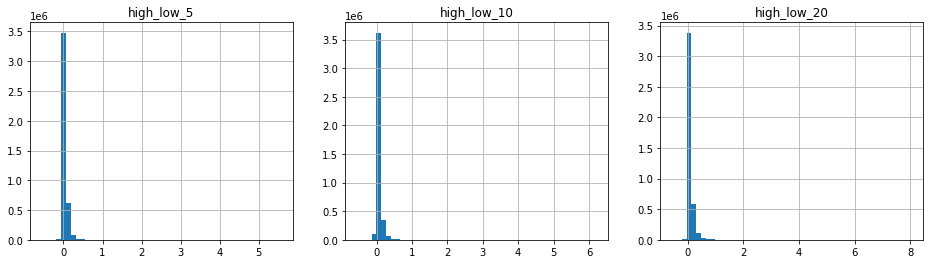

In [14]:
# high-lowの差分
stock_labels['high_low_5'] = stock_labels['label_high_5'] - stock_labels['label_low_5']
stock_labels['high_low_10'] = stock_labels['label_high_10'] - stock_labels['label_low_10']
stock_labels['high_low_20'] = stock_labels['label_high_20'] - stock_labels['label_low_20']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
stock_labels['label_high_5'].hist(bins=50)
plt.title('high_low_5')

plt.subplot(1, 3, 2)
stock_labels['label_high_10'].hist(bins=50)
plt.title('high_low_10')

plt.subplot(1, 3, 3)
stock_labels['label_high_20'].hist(bins=50)
plt.title('high_low_20')

Text(0.5, 1.0, 'center_20')

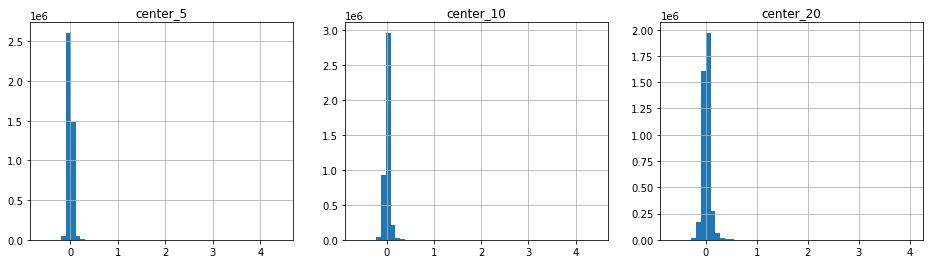

In [15]:
# high-lowの中間
stock_labels['center_5'] = (stock_labels['label_high_5'] + stock_labels['label_low_5']) / 2
stock_labels['center_10'] = (stock_labels['label_high_10'] + stock_labels['label_low_10']) / 2
stock_labels['center_20'] = (stock_labels['label_high_20'] + stock_labels['label_low_20']) / 2

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
stock_labels['center_5'].hist(bins=50)
plt.title('center_5')

plt.subplot(1, 3, 2)
stock_labels['center_10'].hist(bins=50)
plt.title('center_10')

plt.subplot(1, 3, 3)
stock_labels['center_20'].hist(bins=50)
plt.title('center_20')

<メモ>  
中間値をとると、期間幅が伸びても最大で4程度で収まるようになった。(予測のブレが減る？)  
モデルの予測としては以下のパターンが考えられる  
* 最大値・最小値を予測するモデル  
* 中間値・幅(最大値ー最小値)を予測し、そこから最大値・最小値を算出するモデル  
* 1点目と2点目の合わせ技:予測値の平均をとる  

やっていることは同じかもしれないが、意味があるのかもしれない。

### 特徴量の生成
<テクニカル指標>  
* 移動平均乖離率(5日、25日、75日)
* ヒストリカルボラティリティ(5日、25日、75日)
* 過去n日間の最高値に対する終値・高値（安値)との乖離率(n=5, 10, 20)
* キリ番との乖離率(9,999円未満の株価は100円台を基準、 10,000円は1000円台を基準)  
* RSI

今回の予測対象は最大値と最小値であるため。高値と安値に関する指標あったほうがよさそう。  
実際、株価は過去の株価の高値や安値をサポートラインとすることが多い。  
キリ番(キリが良い番号。100円とか)もサポートラインになることが多い。  
  
<ファンダメンタル指標>
* 売上高営業利益率, 売上高経常利益率, 売上高当期純利益率 
* 前期比(成長率)  
* 来期予想成長率  
* 自己資本比率
* ROE(当期純利益÷自己資本)
* ROA
* PER, PBRは用意されたデータセットの発行済み株式数では未来情報のため利用しない
* キャッシュフローの正負(四半期データは欠損値となっている。それらはゼロにする)
* 配当利回り  
  欠損値が少ない一株当たりの四半期配当金を利用する。欠損値は、データの開始時点から1年が多く見られるため、問題なさそう。

価格情報の利用を避けるため率に変換する。  

In [16]:
from decimal import Decimal, ROUND_HALF_UP

def calc_MADR(close:pd.core.series.Series, days:int) -> np.ndarray:
    '''移動平均乖離率を計算する'''
    MA = close.rolling(days).mean()
    MADR = ((close - MA) / MA).replace([np.inf, -np.inf], 0)
    return MADR.values

def calc_MXDR(high:pd.core.series.Series, days:int) -> np.ndarray:
    '''最高値乖離率を計算する'''
    MX = high.rolling(days).max()
    MXDR = ((high - MX) / MX).replace([np.inf, -np.inf], 0)
    return MXDR.values

def calc_MNDR(min_:pd.core.series.Series, days:int) -> np.ndarray:
    '''最安値乖離率を計算する'''
    MN = min_.rolling(days).min()
    MNDR = ((min_ - MN) / MN).replace([np.inf, -np.inf], 0)
    return MNDR.values

def calc_RNDR(close:int) -> int:
    '''キリ番(Round Number Divergence Rate...造語)との乖離率を計算する'''
    # 10円台, 1000円台, 10000円台ではスケールが異なる。
    # 99円までは10円を基準, 9999円までは100円を基準, 10000以上は1000円基準としてみる。
    #株価は0～93600の範囲をとりうる
    if close < 100:
        RN =int(Decimal(close).quantize(Decimal('1E1'), rounding=ROUND_HALF_UP))
    elif close < 10000:
        RN =int(Decimal(close).quantize(Decimal('1E2'), rounding=ROUND_HALF_UP))
    else:
        RN =int(Decimal(close).quantize(Decimal('1E3'), rounding=ROUND_HALF_UP))
    # 終値がキリ番の場合はゼロなり割れない為、場合分け
    if close - RN != 0:
        RNDR = (close - RN) / RN
    else:
        RNDR = 0
    return RNDR

def calc_RSI(close, day):
    '''RSIを計算する'''
    RSI = (close.diff().apply(lambda x: x if x >=0 else 0).rolling(day).sum() / close.diff().abs().rolling(day).sum()).replace([np.inf, -np.inf], 0)
    return RSI.values

def add_techniacl_data(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
    dfにテクニカル指標を追加
    '''
    df = df_target.copy()
    
    # 対数リターン(前日比)
    df["log_R"] = np.log1p(df["EndOfDayQuote ExchangeOfficialClose"]).diff()
    
    # リターン(変化率)
    df["return_5"] = df["EndOfDayQuote ExchangeOfficialClose"].pct_change(5)
    df["return_25"] = df["EndOfDayQuote ExchangeOfficialClose"].pct_change(25)
    df["return_75"] = df["EndOfDayQuote ExchangeOfficialClose"].pct_change(75)
    
    # ヒストリカルボラティリティ
    df["HV_5"] = df['log_R'].diff().rolling(5).std()
    df["HV_25"] = df['log_R'].diff().rolling(25).std()
    df["HV_75"] = df['log_R'].diff().rolling(75).std()
    
    # 移動平均乖離(Moving Average Divergence Rate)を求める
    df['MADR5'] =  calc_MADR(df['EndOfDayQuote ExchangeOfficialClose'], 5)
    df['MADR25'] =  calc_MADR(df['EndOfDayQuote ExchangeOfficialClose'], 25)
    df['MADR75'] =  calc_MADR(df['EndOfDayQuote ExchangeOfficialClose'], 75)
    
    # 最高値との乖離
    df['MXDR5'] =  calc_MXDR(df['EndOfDayQuote High'], 5)
    df['MXDR10'] =  calc_MXDR(df['EndOfDayQuote High'], 10)
    df['MXDR20'] =  calc_MXDR(df['EndOfDayQuote High'], 20)
    
    # 最高値との乖離
    df['MNDR5'] =  calc_MNDR(df['EndOfDayQuote Low'], 5)
    df['MNDR10'] =  calc_MNDR(df['EndOfDayQuote Low'], 10)
    df['MNDR20'] =  calc_MNDR(df['EndOfDayQuote Low'], 20)
    
    # キリ番との乖離
    df['RNDR'] =  df['EndOfDayQuote ExchangeOfficialClose'].apply(calc_RNDR)
    
    # RSI
    df['RSI'] = calc_RSI(df["EndOfDayQuote ExchangeOfficialClose"], 14)
    
    # 欠損値は削除
    df.dropna(inplace=True)
    
    return df

In [17]:
def clean_base_date_index(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
    更新対応処理:修正開示が20営業日以内の場合は修正前のデータはdfから削除する。
    20日以上の場合は、修正後のデータを削除する。今回は簡単のため、営業日基準とはしない。
    '''
    # 前処理
    df = df_target.copy()
    df['Result_FinancialStatement ModifyDate'] = pd.to_datetime(df['Result_FinancialStatement ModifyDate'])

    # 修正となったインデックス取得
    modify_index = np.where(df['Result_FinancialStatement ModifyDate'] != df.index)

    # 更新日
    modify_dates = df.index[modify_index]

    # 修正元の情報開示日
    base_dates = df.loc[modify_dates]['Result_FinancialStatement ModifyDate'].values

    # 差分を取り、判定
    diff_days = modify_dates - base_dates
    mask1 = [d.days <= 20 for d in diff_days]
    mask2 = [d.days > 20 for d in diff_days]
    
    # 修正前の情報開示日が20日以内のインデックス削除
    df = df.drop(base_dates[mask1]).copy()
    
    # 更新日が20日より後のインデックス削除
    df = df.drop(modify_dates[mask2]).copy()
    
    return df

def add_growth(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''前期同期比の成長率を計算する'''
    df = df_target.sort_values(['Result_FinancialStatement ReportType', 'base_date']).copy()
    
    # 売上高成長率, 営業利益成長率, 経常利益成長率, 営業利益成長率
    df['NetSales_Growth'] = df['Result_FinancialStatement NetSales'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    df['OperatingIncome_Growth'] = df['Result_FinancialStatement OperatingIncome'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    df['OrdinaryIncome_Growth'] = df['Result_FinancialStatement OrdinaryIncome'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    df['NetIncome_Growth'] = df['Result_FinancialStatement NetIncome'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)

    # ReportTypeの変わり目(各レポートの最初のデータ)は0とする
    report_change_mask = df['Result_FinancialStatement ReportType'].ne(df['Result_FinancialStatement ReportType'].shift()).values
    report_change_ind = df.index[np.where(report_change_mask)]
    df.loc[report_change_ind, ['NetSales_Growth', 'OperatingIncome_Growth', 'OrdinaryIncome_Growth', 'NetIncome_Growth']] = 0
    
    # 順序を戻す(しなくてもいが)
    df = df.sort_values('base_date').copy()
    
    return df
    
def add_fundamental_data(df_target: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    df = df_target.copy()
    
    # 更新対応処理
    df = clean_base_date_index(df)
    
    # 売上高営業利益率, 売上高経常利益率, 売上高当期純利益
    df['OperatingIncome_NetSales'] = (df['Result_FinancialStatement OperatingIncome'] / df['Result_FinancialStatement NetSales']).replace([np.inf, -np.inf], 0)
    df['OrdinaryIncome_NetSales'] = (df['Result_FinancialStatement OrdinaryIncome'] / df['Result_FinancialStatement NetSales']).replace([np.inf, -np.inf], 0)
    df['NetIncome_NetSales'] = (df['Result_FinancialStatement NetIncome'] / df['Result_FinancialStatement NetSales']).replace([np.inf, -np.inf], 0)
    
    # 前年度期比の売上高成長率, 営業利益成長率, 経常利益成長率, 営業利益成長率
    df = add_growth(df)
    
    # 来期予想成長率
    df['Forecast_NetSales_Growth'] = (df['Forecast_FinancialStatement NetSales'] / df['Result_FinancialStatement NetSales']-1).replace([np.inf, -np.inf], 0)
    df['Forecast_OperatingIncome_Growth'] = (df['Forecast_FinancialStatement OperatingIncome'] / df['Result_FinancialStatement OperatingIncome']-1).replace([np.inf, -np.inf], 0)
    df['Forecast_OrdinaryIncome_Growth'] = (df['Forecast_FinancialStatement OrdinaryIncome'] / df['Result_FinancialStatement OrdinaryIncome']-1).replace([np.inf, -np.inf], 0)
    df['Forecast_NetIncome_Growth'] = (df['Forecast_FinancialStatement NetIncome'] / df['Result_FinancialStatement NetIncome']-1).replace([np.inf, -np.inf], 0)
    
    # 自己資本比率, ROE, ROA
    df['Capital_Ratio'] = (df['Result_FinancialStatement NetAssets'] / df['Result_FinancialStatement TotalAssets']).replace([np.inf, -np.inf], 0)
    df['ROE'] = (df['Result_FinancialStatement NetIncome'] / df['Result_FinancialStatement NetAssets']).replace([np.inf, -np.inf], 0)
    df['ROA'] = (df['Result_FinancialStatement NetIncome'] / df['Result_FinancialStatement TotalAssets']).replace([np.inf, -np.inf], 0)
    
    # キャッシュフローの正負(1, 0, -1):pn(positive, negative)
    df['CF_Operating_pn'] = np.sign(df['Result_FinancialStatement CashFlowsFromOperatingActivities']).fillna(0)
    df['CF_Financing_pn'] = np.sign(df['Result_FinancialStatement CashFlowsFromFinancingActivities']).fillna(0)
    df['CF_Investing_pn'] = np.sign(df['Result_FinancialStatement CashFlowsFromInvestingActivities']).fillna(0)

    return df    

In [18]:
codes = sorted(set(stock_price['Local Code'].values))

In [19]:
for i, code in enumerate(codes):
    # 1銘柄に関する価格情報を取り出す
    df_one_code = stock_price.loc[stock_price['Local Code'] == code].copy()
    
    # テクニカル指標を追加
    df_one_code_tech = add_techniacl_data(df_one_code).copy()
    
    # 1銘柄に関する財務諸表データ
    df_one_code_fund = stock_fin.loc[stock_fin['Local Code'] == code].copy()
    
    # ファンダメンタル指標を追加
    df_one_code_fund = add_fundamental_data(df_one_code_fund).copy()
    
    # テクニカル指標とファンダメンタル指標を結合
    df_one_code_merged = df_one_code_tech.set_index('EndOfDayQuote Date').copy()
    df_one_code_merged.index = pd.to_datetime(df_one_code_merged.index)
    df_one_code_merged = df_one_code_merged.join(df_one_code_fund, how='inner', rsuffix='_fund')
    
    # 配当利回りを計算
    df_one_code_merged['Dividend_Yeild'] = (df_one_code_merged['Result_Dividend QuarterlyDividendPerShare'] / df_one_code_merged["EndOfDayQuote ExchangeOfficialClose"]).replace([np.inf, -np.inf], 0)
    
    if i == 0:
        df_all_code_merged = df_one_code_merged.copy()
    else:
        df_all_code_merged = pd.concat([df_all_code_merged, df_one_code_merged], axis=0)

In [20]:
print(df_all_code_merged.shape)
df_all_code_merged.head(3)

(64679, 94)


,Local Code,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,log_R,return_5,return_25,return_75,HV_5,HV_25,HV_75,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,Local Code_fund,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,CF_Operating_pn,CF_Financing_pn,CF_Investing_pn,Dividend_Yeild
2016-05-09,1301,2590.0,2650.0,2590.0,2610.0,2610.0,23100.0,0.1,2580.0,2016/05/06,2580.0,2016/05/06,30.0,1.163,2620.563,0.011556,-0.003817,-0.003817,-0.015094,0.014385,0.020458,0.019105,0.006168,0.004155,-0.009914,-0.003759,-0.014870,-0.014870,0.015686,0.015686,0.023715,0.003846,0.526316,1301,ConsolidatedJP,2016/03,Annual,2016.0,2016-05-09,GB,False,226626.0,2433.0,2814.0,1799.0,94608.0,23065.0,2689.0,2482.0,-5114.0,ConsolidatedJP,2016/09,Q2,2017.0,2016/05/09,GB,False,117000.0,1400.0,1300.0,800.0,2016/03,Annual,2016.0,2016/05/09,2016/03/31,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/05/09,2017/03/31,50.0,50.0,0.010736,0.012417,0.007938,0.0,0.0,0.0,0.0,-0.483731,-0.424579,-0.538024,-0.555309,0.243795,0.077997,0.019015,1.0,1.0,-1.0,0.001916
2016-08-05,1301,2610.0,2620.0,2590.0,2600.0,2600.0,8900.0,0.1,2610.0,2016/08/04,2610.0,2016/08/04,-10.0,-0.383,2606.067,-0.003837,-0.018868,0.000000,-0.007634,0.010664,0.015279,0.015602,-0.006116,-0.010956,-0.012408,-0.011321,-0.015038,-0.015038,0.000000,0.000000,0.007782,0.000000,0.411765,1301,ConsolidatedJP,2016/06,Q1,2017.0,2016-08-05,GB,False,52206.0,467.0,380.0,551.0,101632.0,22995.0,NaN,NaN,NaN,ConsolidatedJP,2016/09,Q2,2017.0,2016/08/05,GB,False,117000.0,1400.0,1300.0,800.0,2016/03,Annual,2016.0,2016/08/05,2016/03/31,2016/06/27,5.0,5.0,2017/03,Annual,2017.0,2016/08/05,2017/03/31,50.0,50.0,0.008945,0.007279,0.010554,0.0,0.0,0.0,0.0,1.241122,1.997859,2.421053,0.451906,0.2262

In [21]:
# save
df_all_code_merged.to_csv('../data/all_code_tech_fund.csv')

## 説明変数間の分析

In [22]:
explain_variables = ['log_R', 'return_5', 'return_25', 'return_75', 'HV_5', 'HV_25', 'HV_75', 'MADR5', 'MADR25',
                     'MADR75', 'MXDR5', 'MXDR10', 'MXDR20', 'MNDR5', 'MNDR10', 'MNDR20', 'RNDR', 'RSI', 'OperatingIncome_NetSales',
                     'OrdinaryIncome_NetSales', 'NetIncome_NetSales', 'NetSales_Growth', 'OperatingIncome_Growth',
                     'OrdinaryIncome_Growth', 'NetIncome_Growth', 'Forecast_NetSales_Growth', 'Forecast_OperatingIncome_Growth',
                     'Forecast_OrdinaryIncome_Growth', 'Forecast_NetIncome_Growth', 'Capital_Ratio', 'ROE', 'ROA',
                     'CF_Operating_pn', 'CF_Financing_pn', 'CF_Investing_pn', 'Dividend_Yeild']

print('生成した説明変数の数:', len(explain_variables))

生成した説明変数の数: 36


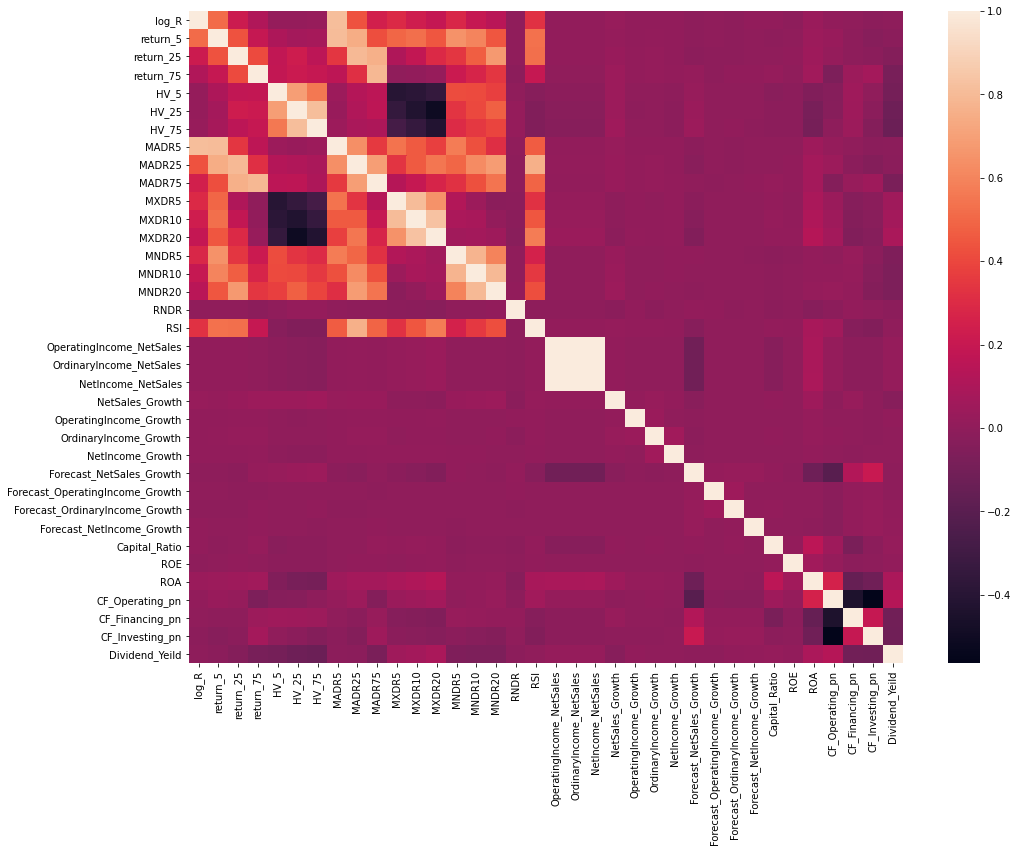

In [23]:
# 数値データ(比率)のみで相関を見る
corr_mat = df_all_code_merged.loc[:, explain_variables].corr(method='pearson')
plt.figure(figsize=(16, 12))
sns.heatmap(corr_mat)

## 目的変数の分析

In [24]:
Y_cols = ['label_high_5', 'label_low_5', 'label_high_10', 'label_low_10', 'label_high_20', 'label_low_20', 
          'high_low_5', 'high_low_10', 'high_low_20', 'center_5', 'center_10', 'center_20']

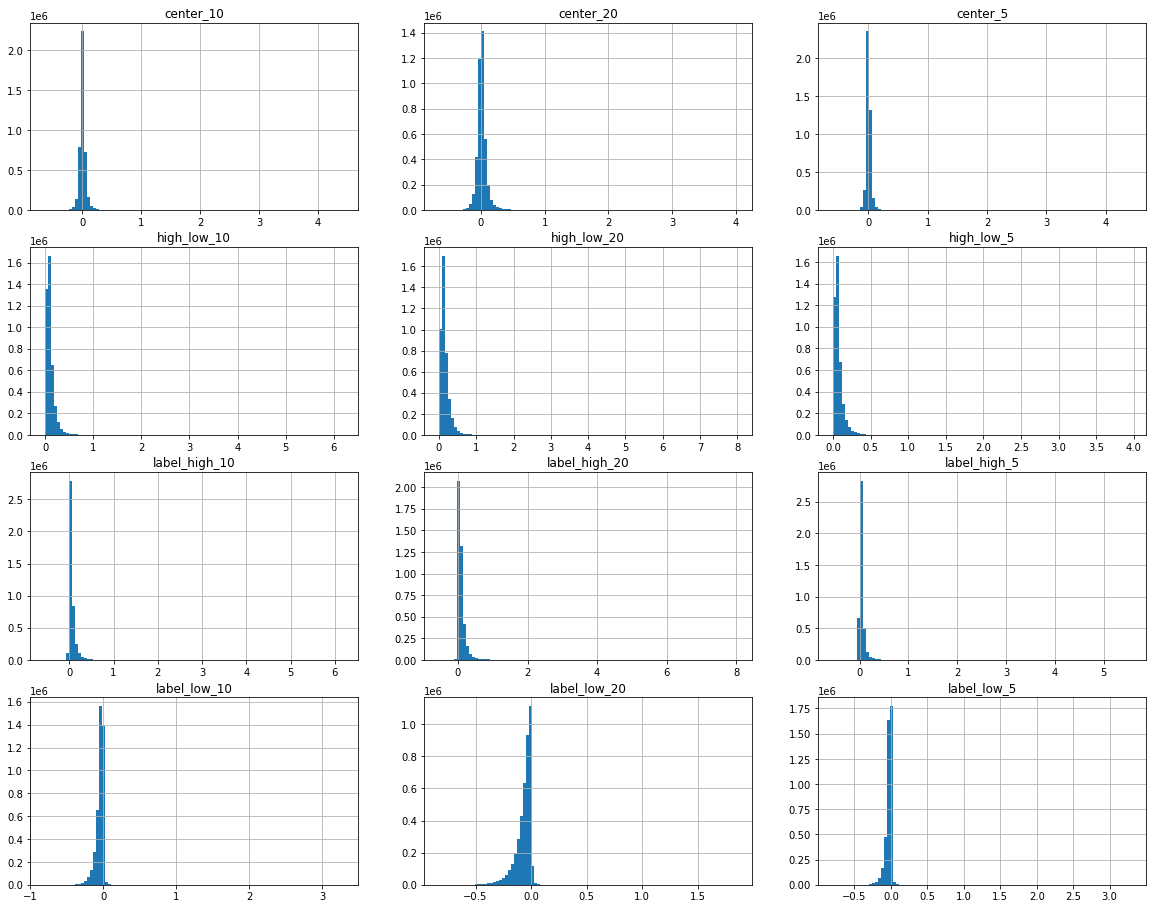

In [25]:
plt.figure(figsize=(20, 20))
for i, y_col in enumerate(sorted(Y_cols)):
    plt.subplot(5, 3, i+1)
    stock_labels[y_col].hist(bins=100)
    plt.title(y_col)

## 説明変数と目的変数の分析

In [26]:
stock_labels.head()

,base_date,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,high_low_5,high_low_10,high_low_20,center_5,center_10,center_20
0,2016-01-04,1301,2016-01-12,0.01091,-0.04000,2016-01-19,0.01091,-0.05455,2016-02-02,0.01091,-0.08727,0.05091,0.06546,0.09818,-0.014545,-0.021820,-0.03818
1,2016-01-05,1301,2016-01-13,0.00362,-0.04348,2016-01-20,0.00362,-0.07609,2016-02-03,0.00362,-0.09058,0.04710,0.07971,0.09420,-0.019930,-0.036235,-0.04348
2,2016-01-06,1301,2016-01-14,0.00000,-0.05072,2016-01-21,0.00000,-0.08696,2016-02-04,0.00362,-0.09058,0.05072,0.08696,0.09420,-0.025360,-0.043480,-0.04348
3,2016-01-07,1301,2016-01-15,0.01107,-0.03321,2016-01-22,0.01107,-0.07380,2016-02-05,0.02214,-0.07380,0.04428,0.08487,0.09594,-0.011070,-0.031365,-0.02583
4,2016-01-08,1301,2016-01-18,0.01111,-0.03333,2016-01-25,0.01111,-0.07037,2016-02-08,0.02593,-0.07037,0.04444,0.08148,0.09630,-0.011110,-0.029630,-0.02222


In [27]:
# 説明変数と目的変数を結合したdfを作成する
X_cols = explain_variables.copy()
X_cols.insert(0, 'Local Code')
X = df_all_code_merged.loc[:, X_cols]
X.reset_index(inplace=True)
X.rename(columns={'index':'base_date'}, inplace=True)

# merge
stock_labels.base_date = pd.to_datetime(stock_labels.base_date)
XY = pd.merge(X, stock_labels, on=['base_date', 'Local Code']).copy()

XY.head()

,base_date,Local Code,log_R,return_5,return_25,return_75,HV_5,HV_25,HV_75,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,CF_Operating_pn,CF_Financing_pn,CF_Investing_pn,Dividend_Yeild,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,high_low_5,high_low_10,high_low_20,center_5,center_10,center_20
0,2016-05-09,1301,0.011556,-0.003817,-0.003817,-0.015094,0.014385,0.020458,0.019105,0.006168,0.004155,-0.009914,-0.003759,-0.014870,-0.014870,0.015686,0.015686,0.023715,0.003846,0.526316,0.010736,0.012417,0.007938,0.000000,0.000000,0.000000,0.000000,-0.483731,-0.424579,-0.538024,-0.555309,0.243795,0.077997,0.019015,1.0,1.0,-1.0,0.001916,2016-05-16,0.01533,-0.01149,2016-05-23,0.02299,-0.01149,2016-06-06,0.03448,-0.01149,0.02682,0.03448,0.04597,0.001920,0.005750,0.011495
1,2016-08-05,1301,-0.003837,-0.018868,0.000000,-0.007634,0.010664,0.015279,0.015602,-0.006116,-0.010956,-0.012408,-0.011321,-0.015038,-0.015038,0.000000,0.000000,0.007782,0.000000,0.411765,0.008945,0.007279,0.010554,0.000000,0.000000,0.000000,0.000000,1.241122,1.997859,2.421053,0.451906,0.226257,0.023962,0.005422,0.0,0.0,0.0,0.001923,2016-08-15,0.02692,0.00385,2016-08-22,0.02692,0.00000,2016-09-05,0.02692,0.00000,0.02307,0.02692,0.02692,0.015385,0.013460,0.013460
2,2016-11-04,1301,-0.023082,-0.025298,-0.013533,0.033333,0.009818,0.009007,0.010838,-0.019130,-0.019815,0.004634,-0.003242,-0.004676,-0.006463,0.000000,0.000000,0.000000,-0.001111,0.354430,0.010687,0.009163,0.010824,0.000000,0.000000,0.000000,0.000000,1.226887,1.988898,2.286853,0.770658,0.221484,0.050254,0.011131,0.0,0.0,0.0,0.001854,2016-11-11,0.00000,-0.03967,2016-11-18,0.00000,-0.03967,2016-12-05,0.00779,-0.03967,0.03967,0.03967,0.04746,-0.019835,-0.019835,-0.015940
3,2017-02-17,1301,0.000354,0.029508,0.038207,0.021323,0.007324,0.007095,0.008334,0.005122,0.030920,0.041907,-0.002816,-0.002816,-0.002816,0.019956,0.034216,0.036504,0.009286,0.815068,0.015958,0.015708,0.013607,0.006065,0.164167,0.051711,1.161518,0.355744,0.218663,0.167315,-0.142507,0.220017,0.095000,0.020902,0.0,0.0,0.0,0.001769,2017-02-24,0.04246,0.00177,2017-03-03,0.07749,0.00177,2017-03-17,0.13588,0.00177,0.04069,0.07572,0.13411,0.022115,0.039630,0.068825
4,2017-05-11,1301,0.016579,0.035775,0.009967,0.110705,0.012836,0.012920,0.012303,0.018153,0.036481,0.035992,0.000000,0.000000,0.000000,0.013988,0.022008,0.041710,0.013333,0.777778,0.015738,0.015679,0.010238,0.043839,0.530210,0.318053,0.346304,0.056810,0.074402,0.078458,0.114781,0.260712,0.095388,0.024869,1.0,1.0,-1.0,0.019737,2017-05-18,0.01480,-0.02632,2017-05-25,0.04441,-0.02632,2017-06-08,0.04441,-0.02632,0.04112,0.07073,0.07073,-0.005760,0.009045,0.009045


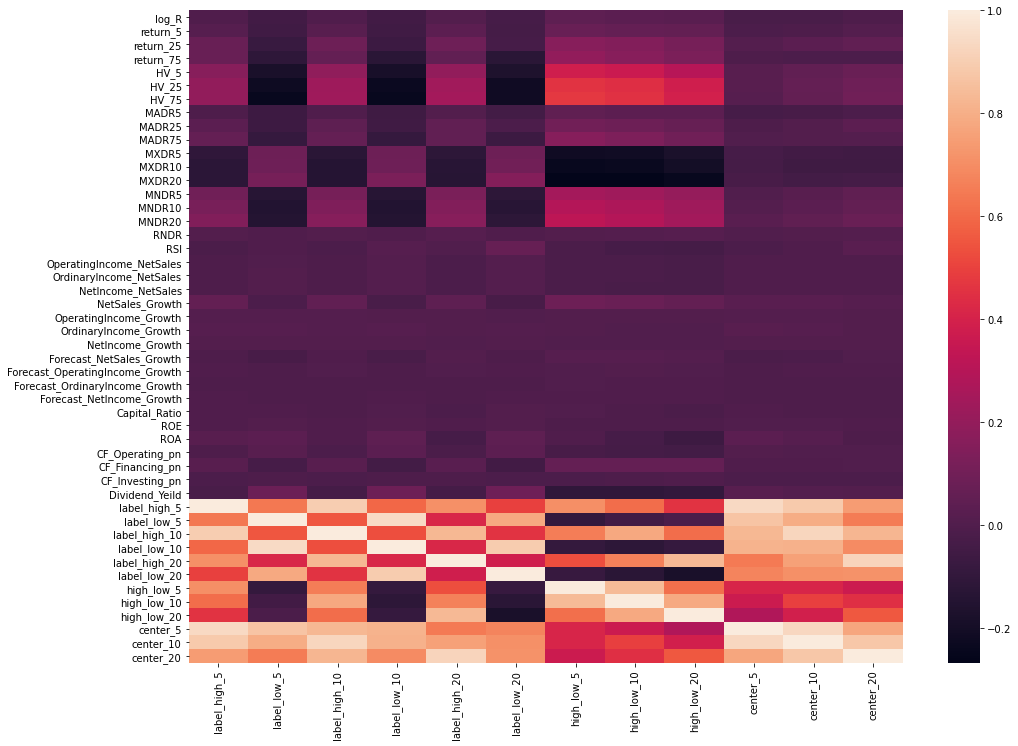

In [28]:
# 相関を見る
Y_cols = ['label_high_5', 'label_low_5', 'label_high_10', 'label_low_10', 'label_high_20', 'label_low_20', 
          'high_low_5', 'high_low_10', 'high_low_20', 'center_5', 'center_10', 'center_20']

plt.figure(figsize=(16, 12))
corr_mat = XY.drop(['Local Code'], axis=1).corr(method='pearson')
sns.heatmap(corr_mat.loc[:, Y_cols])

<メモ>  
* ヒストリカルボラティリティは最大・最小に関するラベルデータに対して相関がある。  
  最大・最小変化率の差に関しては、かなり相関がある。  
  ⇒ボラティリティは重要な変数になると思われる。  
* 移動平均乖離率(MADR)は期間が延びるにつれ、相関係数が高くなっている。  
* 最大値との乖離と最大変化率(n=5, 10, 20)や最大・最小変化率との差は負の負の相関が-0.2程度あることがわかる。  
* 最小値との乖離率は、最大値との変化率と反対方法に同様の相関がある。
* ファンダメンタル指標は全体的に相関関係が薄い。  
  キャッシュフローや配当利回りは、相関が高い。
* 当然だが、5日, 10日, 20日のラベルデータはかなり相関がある。
  
全体的にテクニカル指標の方がファンダメンタル指標に比べ、ラベルデータを捉えるファクターとなりそうである。  
今回のような短期的な価格変化(20営業日)では、テクニカル指標が重要そうである。  
長期的な価格変化になると、ファンダメンタルの説明力が増すのかもしれない。  


In [29]:
XY.to_csv('../data/XY.csv', index=False)

In [30]:
XY.describe()

,Local Code,log_R,return_5,return_25,return_75,HV_5,HV_25,HV_75,MADR5,MADR25,MADR75,MXDR5,MXDR10,MXDR20,MNDR5,MNDR10,MNDR20,RNDR,RSI,OperatingIncome_NetSales,OrdinaryIncome_NetSales,NetIncome_NetSales,NetSales_Growth,OperatingIncome_Growth,OrdinaryIncome_Growth,NetIncome_Growth,Forecast_NetSales_Growth,Forecast_OperatingIncome_Growth,Forecast_OrdinaryIncome_Growth,Forecast_NetIncome_Growth,Capital_Ratio,ROE,ROA,CF_Operating_pn,CF_Financing_pn,CF_Investing_pn,Dividend_Yeild,label_high_5,label_low_5,label_high_10,label_low_10,label_high_20,label_low_20,high_low_5,high_low_10,high_low_20,center_5,center_10,center_20
count,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,64679.000000,62687.000000,64553.000000,64652.000000,64679.000000,64679.000000,64679.000000,64679.000000,59320.000000,58164.000000,59245.000000,59962.000000,64678.000000,64675.000000,64675.000000,64679.000000,64679.000000,64679.000000,64540.000000,64606.000000,64606.000000,64622.000000,64622.000000,64445.000000,64445.000000,64606.000000,64622.000000,64445.000000,64606.000000,64622.000000,64445.000000
mean,5776.770822,0.001912,0.005493,0.020698,0.041783,0.030583,0.029787,0.032601,0.002433,0.009483,0.013748,-0.017189,-0.029857,-0.045817,0.020929,0.036353,0.059796,0.002236,0.526674,-0.074337,-0.068838,-0.093081,0.042501,0.012128,-0.025987,-0.007796,0.845428,0.586908,0.664875,0.788426,0.527572,0.017979,0.016645,0.186614,-0.110855,-0.191561,0.010263,0.043545,-0.044912,0.060479,-0.055807,0.087544,-0.073017,0.088457,0.116286,0.160561,-0.000683,0.002336,0.007264
std,2388.143657,0.031940,0.058558,0.125821,0.250804,0.024327,0.018204,0.016936,0.030827,0.066215,0.109550,0.028321,0.042007,0.057527,0.033661,0.054543,0.085574,0.052172,0.168660,5.904287,5.894875,5.873705,0.476915,9.880387,8.633348,19.164059,2.281842,22.318484,16.804125,21.237920,0.216118,2.232675,0.066709,0.473445,0.495116,0.470743,0.013411,0.092383,0.065789,0.115439,0.072856,0.161663,0.090154,0.071055,0.098430,0.151738,0.071897,0.083036,0.106655
min,1301.000000,-0.405465,-0.559085,-0.700000,-0.792116,0.000000,0.000323,0.001584,-0.336934,-0.624353,-0.679285,-0.564162,-0.637681,-0.683424,0.000000,0.000000,0.000000,-0.300000,0.000000,-843.000000,-841.000000,-837.000000,-76.142857,-342.750000,-576.312500,-1633.000000,-1.000000,-2726.000000,-1701.000000,-850.000000,-1.564972,-205.000000,-3.669746,-1.000000,-1.000000,-1.000000,0.000000,-0.272730,-0.578010,-0.272730,-0.588460,-0.272730,-0.720450,0.000000,0.000000,0.000000,-0.379425,-0.407825,-0.477580
25%,3681.000000,-0.011911,-0.021462,-0.039044,-0.081260,0.015183,0.017953,0.020823,-0.011466,-0.022128,-0.041813,-0.023639,-0.041777,-0.065538,0.000000,0.000896,0.007002,-0.016667,0.411290,0.016914,0.018526,0.009928,-0.024291,-0.244403,-0.257507,-0.347088,0.263338,-0.396778,-0.402348,-0.452371,0.376193,0.009918,0.003601,0.000000,0.000000,0.000000,0.000000,0.000000,-0.075190,0.002900,-0.089228,0.009970,-0.108460,0.046443,0.061070,0.082000,-0.034272,-0.037512,-0.042030
50%,6060.000000,0.000388,0.003759,0.010714,0.012155,0.024309,0.025390,0.028720,0.001599,0.006979,0.006494,-0.005747,-0.014993,-0.026723,0.009901,0.021112,0.037736,0.000000,0.526316,0.049305,0.052562,0.034371,0.003008,0.000000,0.000000,0.000000,0.849978,0.364803,0.338583,0.280683,0.535866,0.034404,0.016581,0.000000,0.000000,0.000000,0.007983,0.022580,-0.034850,0.032610,-0.043385,0.048950,-0.054220,0.071540,0.092770,0.123980,-0.004540,-0.003507,-0.000820
75%,7806.000000,0.015084,0.030121,0.065574,0.120930,0.038325,0.036372,0.040435,0.015592,0.038365,0.058523,0.000000,0.000000,-0.004177,0.029381,0.050000,0.081575,0.016667,0.643678,0.092550,0.100000,0.069119,0.077408,0.179754,0.196724,0.217995,1.109121,1.102041,1.058824,1.010331,0.695980,0.071423,0.036493,0.000000,0.000000,0.000000,0.015299,0.067800,-0.007490,0.088080,-0.012240,0.11

<メモ>
* セクター情報は説明変数に含めてもよいかもしれない
* 季節性として決算期もあってもよいかもしれない
* 銘柄コードを含めるのは個別銘柄ごとのデータ量が少ない為、厳しい。